<a href="https://colab.research.google.com/github/ewondare/GNN/blob/main/GraphSage_on_PPI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 6.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 14.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 55.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!pip install torch

In [ ]:
!pip install torch-geometric

In [ ]:
!pip install torch-scatter

In [ ]:
!pip install torch-sparse

In [ ]:
!pip isntall torch-cluster

In [ ]:
!pip install torch-spline-conv

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.data import DataLoader
from torch_geometric.nn import SAGEConv
from torch_geometric.datasets import PPI
from sklearn.metrics import f1_score

ModuleNotFoundError: No module named 'torch_geometric'

## Labels in the PPI Dataset

### 1. Multi-Label Classification
The PPI dataset is a **multi-label classification** problem. This means:
- Each **node** (protein) can have **multiple labels**.
- Each label represents a **protein function** (e.g., enzymatic activity, binding).
- The labels are **binary**: For each label, a protein either has it ($1$) or does not have it ($0$).

### 2. Label Representation
For a graph with $N$ nodes and $C$ possible labels:
- The labels are represented as a **binary matrix** $\mathbf{Y} \in \{0, 1\}^{N \times C}$.
- Each row $\mathbf{y}_u \in \{0, 1\}^C$ corresponds to the labels of node $u$.
- For example, if $C = 5$, a node with labels `[1, 0, 1, 0, 1]` has the 1st, 3rd, and 5th functions.

### 3. Example
Suppose we have 3 nodes and 4 possible labels:
$$
\mathbf{Y} = \begin{bmatrix}
1 & 0 & 1 & 0 \\
0 & 1 & 0 & 1 \\
1 & 1 & 0 & 0
\end{bmatrix}
$$
- Node 1 has labels 1 and 3.
- Node 2 has labels 2 and 4.
- Node 3 has labels 1 and 2.


In [ ]:
# Load the PPI dataset
train_dataset = PPI(root='data/PPI', split='train')
val_dataset = PPI(root='data/PPI', split='val')
test_dataset = PPI(root='data/PPI', split='test')

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

Extracting data/PPI/ppi.zip
Processing...
/usr/local/lib/python3.11/dist-packages/networkx/readwrite/json_graph/node_link.py:287: FutureWarning: 
The default value will be changed to `edges="edges" in NetworkX 3.6.

To make this warning go away, explicitly set the edges kwarg, e.g.:

  nx.node_link_graph(data, edges="links") to preserve current behavior, or
  nx.node_link_graph(data, edges="edges") for forward compatibility.
  warnings.warn(
Done!
/usr/local/lib/python3.11/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


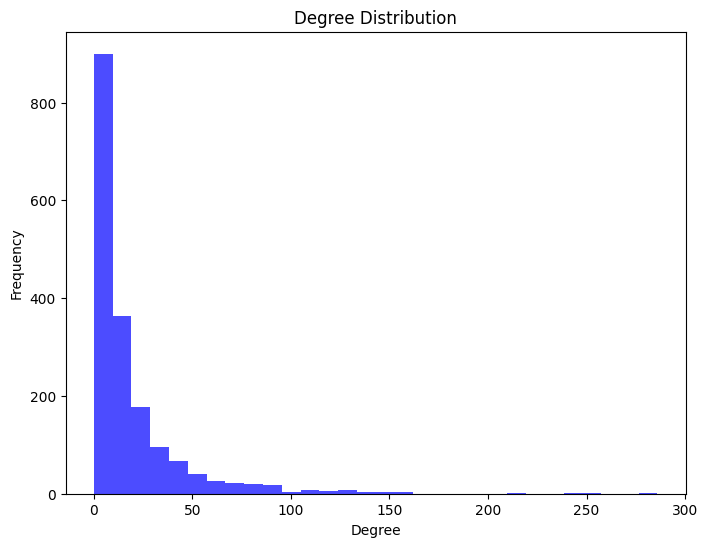

In [ ]:
# Calculate degrees
degrees = [G.degree(node) for node in G.nodes()]

# Plot degree distribution
plt.figure(figsize=(8, 6))
plt.hist(degrees, bins=30, color='blue', alpha=0.7)
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

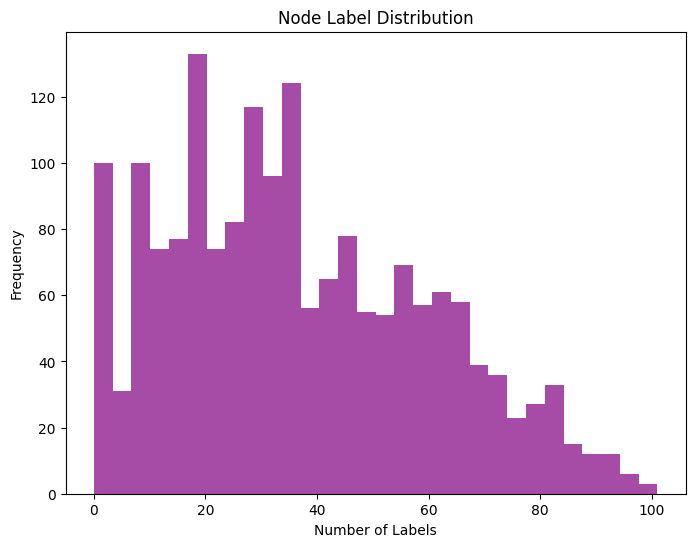

In [ ]:

node_labels = data.y.numpy()

plt.figure(figsize=(8, 6))
plt.hist(node_labels.sum(axis=1), bins=30, color='purple', alpha=0.7)
plt.title("Node Label Distribution")
plt.xlabel("Number of Labels")
plt.ylabel("Frequency")
plt.show()


---

## GraphSAGE Model for Multi-Label Classification

### 1. Model Output
The GraphSAGE model predicts a **probability** for each label. For a node $u$, the model outputs:
$$
\hat{\mathbf{y}}_u = [\hat{y}_{u1}, \hat{y}_{u2}, \dots, \hat{y}_{uC}],
$$
where $\hat{y}_{ui} \in [0, 1]$ is the predicted probability that node $u$ has label $i$.

### 2. Activation Function
The model uses a **sigmoid activation function** to ensure the output probabilities are between 0 and 1:
$$
\hat{y}_{ui} = \sigma(\mathbf{z}_u^\top \mathbf{w}_i),
$$
where:
- $\mathbf{z}_u$ is the embedding of node $u$.
- $\mathbf{w}_i$ is the weight vector for label $i$.
- $\sigma(x) = \frac{1}{1 + e^{-x}}$ is the sigmoid function.

### 3. Loss Function
The model is trained using **binary cross-entropy loss** because each label is treated as an independent binary classification task. For a single node $u$, the loss is:
$$
\text{BCE}(\mathbf{y}_u, \hat{\mathbf{y}}_u) = -\frac{1}{C} \sum_{i=1}^C \left[ y_{ui} \log(\hat{y}_{ui}) + (1 - y_{ui}) \log(1 - \hat{y}_{ui}) \right].
$$
For the entire dataset, the loss is averaged over all nodes:
$$
\mathcal{L} = \frac{1}{N} \sum_{u=1}^N \text{BCE}(\mathbf{y}_u, \hat{\mathbf{y}}_u).
$$


In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers):
        super(GraphSAGE, self).__init__()
        self.num_layers = num_layers

        # Create GraphSAGE layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(SAGEConv(in_channels, hidden_channels))
        for _ in range(num_layers - 2):
            self.convs.append(SAGEConv(hidden_channels, hidden_channels))
        self.convs.append(SAGEConv(hidden_channels, out_channels))

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index)
            if i != self.num_layers - 1:  # Apply ReLU except for the last layer
                x = F.relu(x)
        return x

The SAGEConv layer implements the following steps:

- Aggregation: Aggregates the feature vectors of the neighbors (using mean aggregation by default).

- Transformation: Applies a learnable weight matrix to the aggregated features and combines them with the node's own features.

(after each layer except for the last one, a nonlinearity is also added (ReLU))

In [ ]:
# Define model hyperparameters
in_channels = train_dataset.num_features
hidden_channels = 256
out_channels = train_dataset.num_classes
num_layers = 3 # Number of Hops (K in the paper)


model = GraphSAGE(in_channels, hidden_channels, out_channels, num_layers)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


---

## Training and Evaluation

### 1. Training
During training:
- The model predicts probabilities $\hat{\mathbf{y}}_u$ for all nodes.
- The binary cross-entropy loss is computed by comparing the predictions to the true labels $\mathbf{y}_u$.
- The model parameters are updated using gradient descent.

### 2. Evaluation
During evaluation:
- The model predicts probabilities $\hat{\mathbf{y}}_u$.
- These probabilities are thresholded at 0.5 to obtain binary predictions:
  $$
  \tilde{y}_{ui} = \begin{cases}
  1 & \text{if } \hat{y}_{ui} \geq 0.5, \\
  0 & \text{otherwise}.
  \end{cases}
  $$
- The predictions are compared to the true labels using metrics like **F1 score**:
  $$
  \text{F1} = \frac{2 \cdot \text{precision} \cdot \text{recall}}{\text{precision} + \text{recall}}.
  $$



In [ ]:
def train():
    model.train()
    total_loss = 0

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.binary_cross_entropy_with_logits(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(train_loader)

In [ ]:
def evaluate(loader):
    model.eval()
    preds, labels = [], []

    with torch.no_grad():
        for data in loader:
            out = model(data.x, data.edge_index)
            pred = (out > 0).float()  # Convert logits to binary predictions
            preds.append(pred)
            labels.append(data.y)

    preds = torch.cat(preds, dim=0)
    labels = torch.cat(labels, dim=0)
    return f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='micro')

In [ ]:

for epoch in range(1, 101):
    loss = train()
    val_f1 = evaluate(val_loader)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val F1: {val_f1:.4f}')

test_f1 = evaluate(test_loader)
print(f'Test F1: {test_f1:.4f}')

Epoch: 001, Loss: 0.5493, Val F1: 0.3960
Epoch: 002, Loss: 0.5308, Val F1: 0.4810
Epoch: 003, Loss: 0.4990, Val F1: 0.5627
Epoch: 004, Loss: 0.4672, Val F1: 0.6063
Epoch: 005, Loss: 0.4445, Val F1: 0.6125
Epoch: 006, Loss: 0.4237, Val F1: 0.5910
Epoch: 007, Loss: 0.4087, Val F1: 0.6258
Epoch: 008, Loss: 0.3931, Val F1: 0.6128
Epoch: 009, Loss: 0.3812, Val F1: 0.6676
Epoch: 010, Loss: 0.3665, Val F1: 0.6721
Epoch: 011, Loss: 0.3566, Val F1: 0.6860
Epoch: 012, Loss: 0.3472, Val F1: 0.7082
Epoch: 013, Loss: 0.3401, Val F1: 0.7009
Epoch: 014, Loss: 0.3437, Val F1: 0.6893
Epoch: 015, Loss: 0.3255, Val F1: 0.7078
Epoch: 016, Loss: 0.3242, Val F1: 0.7157
Epoch: 017, Loss: 0.3178, Val F1: 0.7240
Epoch: 018, Loss: 0.3108, Val F1: 0.7246
Epoch: 019, Loss: 0.3085, Val F1: 0.7179
Epoch: 020, Loss: 0.3132, Val F1: 0.7333
Epoch: 021, Loss: 0.3049, Val F1: 0.7320
Epoch: 022, Loss: 0.2936, Val F1: 0.7391
Epoch: 023, Loss: 0.2885, Val F1: 0.7494
Epoch: 024, Loss: 0.2840, Val F1: 0.7437
Epoch: 025, Loss